In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import sys
import os
os.chdir('../')
sys.path.append('.')

In [2]:
# General function to plot X-Y values:
def plot_series(time, series):
    plt.figure(figsize=(10, 6))
    plt.plot(time, series)
    plt.xlabel("time")
    plt.ylabel("value")
    plt.grid(True)
    plt.show()


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    return np.where(
        season_time < 0.4,
        np.cos(season_time * 2 * np.pi),
        1 / np.exp(3 * season_time)
        )

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1):
    return np.random.randn(len(time)) * noise_level     


def autocorrelation(time, amplitude, corr_steps=[1,2,3], rhos=[0.5,0.1,-0.1]):
    max_step = max(corr_steps)
    ar = np.random.randn(len(time) + max_step)
    for step in range(max_step, len(time) + max_step): # Extend range for the delay
        for i, corr in enumerate(corr_steps):
            ar[step] += rhos[i] * ar[step - corr]
    return ar[max_step:] * amplitude

In [236]:
import pandas as pd
# time = np.arange(10 * 365 + 1) # 10 years


def create_time_features(df: pd.DataFrame):

    weekday_sin = np.sin(2*np.pi*(df.index.isocalendar().day/7))
    weekday_cos = np.cos(2*np.pi*(df.index.isocalendar().day/7))
    df['weekday_sin'] = weekday_sin
    df['weekday_cos'] = weekday_cos

    yearweek_sin = np.sin(2*np.pi*(df.index.isocalendar().week/52))
    yearweek_cos = np.cos(2*np.pi*(df.index.isocalendar().week/52))
    df['yearweek_sin'] = yearweek_sin
    df['yearweek_cos'] = yearweek_cos

    month_sin = np.sin(2*np.pi*(df.index.month/12))
    month_cos = np.cos(2*np.pi*(df.index.month/12))
    df['month_sin'] = month_sin
    df['month_cos'] = month_cos

    return df

days = 365*10
index = pd.date_range(start = "2010-01-01", periods=days, freq='D')
time = pd.Series(np.arange(days ), index=index)

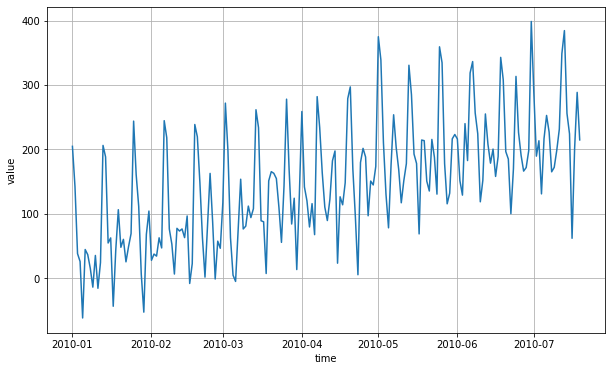

In [238]:
series = (
    autocorrelation(time, amplitude=5, corr_steps=[6,12], rhos=[0.5,-0.5]) 
    +  
    seasonality(time, period=12, amplitude=150) 
    +  
    seasonality(time, period=6, amplitude=50) 
    +  
    trend(time, 1) 
    + 
    noise(time, noise_level=30)
)
plot_series(time[:200].index, series[:200])

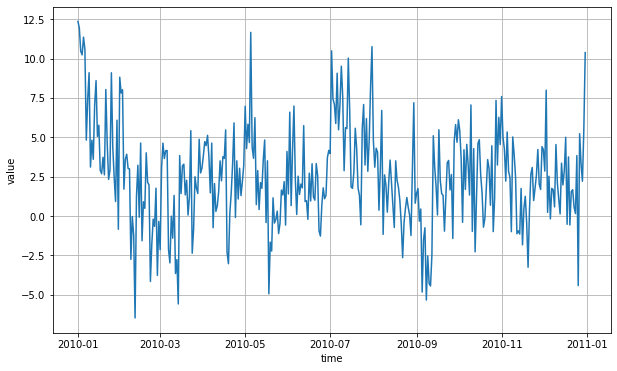

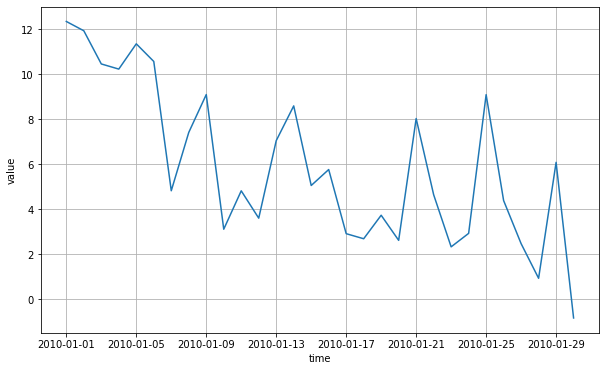

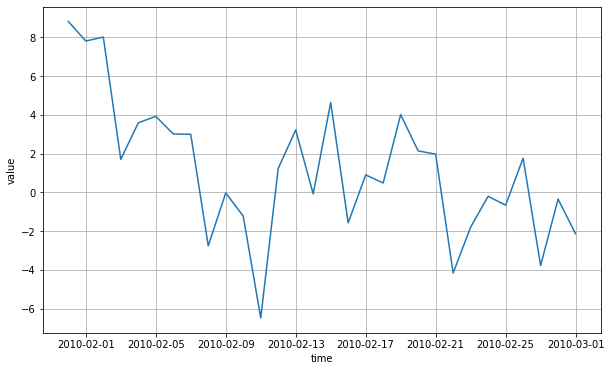

In [245]:
# add external features

x1 = np.random.normal(size=series.shape[0])

series = (
    # autocorrelation(time, amplitude=1, corr_steps=[1,2], rhos=[0.5,-0.5]) 
    # + 
    seasonality(time, period=365//2, amplitude=5) 
    + 
    seasonality(time, period=365//6, amplitude=3) 
    +  
    seasonality(time, period=365//12, amplitude=2) 
    +  
    seasonality(time, period=7, amplitude=1.3) 
    +  
    trend(time, 0.001) 
    # + 
    # noise(time, noise_level=0)
)

series = series + 2*x1

plot_series(time[:365].index, series[:365])
plot_series(time[:30].index, series[:30])
plot_series(time[30:60].index, series[30:60])

In [278]:


data = pd.DataFrame({"feature":x1,"target":series}, index=time.index)
data = create_time_features(data)

# X = x1[...,np.newaxis]
# y_series = series
X = data.drop(columns=['target']).values
y_series = data['target'].values

X.shape

(3650, 7)

In [279]:
# Train - Val - Test split
from sklearn.model_selection import train_test_split


train_size=800
val_size=100
test_size=100

X_train, X_test, y_train, y_test = train_test_split(X, y_series, test_size=0.2, shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)




In [280]:

def temporalize(x, n_input_steps, n_pred_steps):
    n_cols = x.shape[1]
    # dataset = dataset.values.astype(np.float64)

    idxs = np.arange(x.shape[0])
    n_timesteps = n_input_steps + n_pred_steps
    n_samples = x.shape[0] - n_timesteps + 1
    stride = idxs.strides[0]
    sample_idxs = np.lib.stride_tricks.as_strided(idxs, shape=(n_samples, n_timesteps), strides=(stride, stride))

    samples = x[sample_idxs]
    useable = np.all(~np.isnan(samples.reshape(-1, n_timesteps*n_cols)), axis=-1)
    s = samples[useable]

    X = samples[:,:n_input_steps,:].copy()
    y = samples[:,n_input_steps:,:].copy()
    print(s.shape[0], f'samples of {n_input_steps} input steps and {n_pred_steps} output steps')
    return X,y


In [282]:
timesteps = 60
n_pred_steps = 1

y_train_temp, y_train_target =  temporalize(y_train[...,np.newaxis], n_input_steps=timesteps, n_pred_steps=n_pred_steps)
y_val_temp, y_val_target =  temporalize(y_val[...,np.newaxis], n_input_steps=timesteps, n_pred_steps=n_pred_steps)
y_test_temp, y_test_target =  temporalize(y_test[...,np.newaxis], n_input_steps=timesteps, n_pred_steps=n_pred_steps)
x_train_temp,x_val_temp,x_test_temp = X_train[timesteps:],X_val[timesteps:],X_test[timesteps:]


2276 samples of 60 input steps and 1 output steps
524 samples of 60 input steps and 1 output steps
670 samples of 60 input steps and 1 output steps


In [285]:
from tensorflow import keras
from src.autoencoder import EncoderDecoder
import tensorflow as tf

y_features = 1
inputs = keras.layers.Input(shape=(timesteps, y_features))
ed = EncoderDecoder(features=y_features, timesteps=timesteps, lstm_units=[32,16,8], dropout=0.1, name='auto_encoder')
outputs = ed(inputs)
auto_encoder = keras.Model(inputs=inputs, outputs=outputs)

In [286]:
auto_encoder.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
auto_encoder.summary()

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_55 (InputLayer)       [(None, 60, 1)]           0         
                                                                 
 auto_encoder (EncoderDecode  (None, 60, 1)            16737     
 r)                                                              
                                                                 
Total params: 16,737
Trainable params: 16,737
Non-trainable params: 0
_________________________________________________________________


In [287]:
history = auto_encoder.fit(
    y_train_temp, 
    y_train_temp, 
    validation_data=(y_val_temp, y_val_temp), 
    epochs=50, 
    batch_size=32
)

Epoch 1/50
72/72 [==============================] - 37s 237ms/step - loss: 20.5991 - mae: 3.7537 - val_loss: 28.8118 - val_mae: 4.5478
Epoch 2/50
72/72 [==============================] - 14s 199ms/step - loss: 16.4207 - mae: 3.2766 - val_loss: 21.9191 - val_mae: 3.8434
Epoch 3/50
72/72 [==============================] - 13s 174ms/step - loss: 12.6723 - mae: 2.8267 - val_loss: 16.8209 - val_mae: 3.3005
Epoch 4/50
72/72 [==============================] - 10s 146ms/step - loss: 11.8106 - mae: 2.7317 - val_loss: 15.2319 - val_mae: 3.1344
Epoch 5/50
72/72 [==============================] - 10s 145ms/step - loss: 11.6469 - mae: 2.7140 - val_loss: 15.0412 - val_mae: 3.1070
Epoch 6/50
72/72 [==============================] - 10s 137ms/step - loss: 11.4474 - mae: 2.6907 - val_loss: 14.7082 - val_mae: 3.0794
Epoch 7/50
72/72 [==============================] - 10s 137ms/step - loss: 11.2509 - mae: 2.6681 - val_loss: 13.4345 - val_mae: 2.9510
Epoch 8/50
72/72 [==============================] - 10s

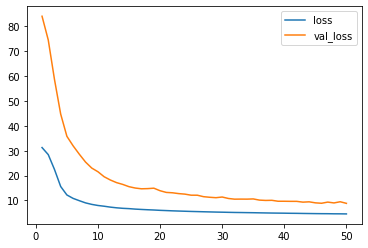

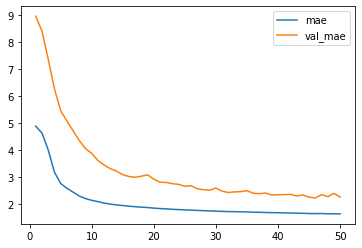

In [172]:
history.history['loss']
history.history['mae']

history.history['val_loss']
history.history['val_mae']

epochs = [i for i in range(1,len(history.history['loss'])+1)]

plt.figure()
plt.plot(epochs,history.history['loss'], label='loss')
plt.plot(epochs,history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs,history.history['mae'], label='mae')
plt.plot(epochs,history.history['val_mae'], label='val_mae')
plt.legend()
plt.show()

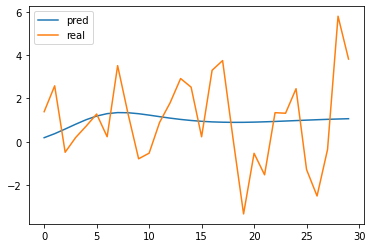

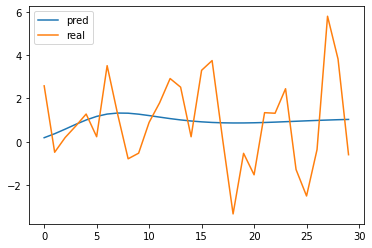

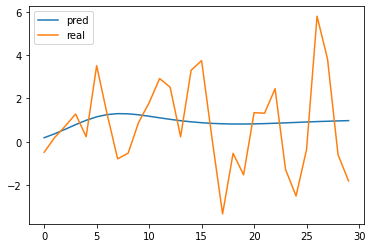

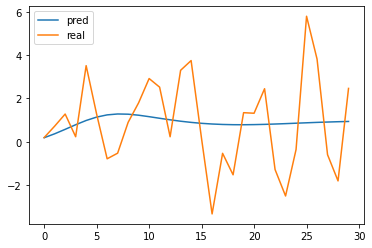

In [173]:
yhat = auto_encoder.predict(y_train_temp[:4], verbose=0)

for i in range(yhat.shape[0]):
    plt.figure()
    plt.plot(np.round(yhat[i],3), label='pred')
    plt.plot(np.round(y_train_temp[i,:,0], 3), label='real')
    plt.legend()

The 'external' features consist of information about the prediction time that we know in advance. For example, the time of day, day of the week, whether or not it is a public holiday etc. By including a mechanism to incorporate such external features, prediction accuracy can be improved.

In [174]:
# Model with External Features
x_features=1
input_series = keras.layers.Input(shape=(timesteps,y_features))
input_external = keras.layers.Input(shape=(x_features))

encoder = auto_encoder.get_layer("auto_encoder").encoder

encoder.trainable = False

y_encoded = encoder(input_series)

x_concat = tf.concat([y_encoded, input_external], axis=-1)

pred_model = keras.Sequential([
    keras.layers.Dense(64),
    keras.layers.Dropout(0.1),
    keras.layers.ReLU(),
    keras.layers.Dense(32),
    keras.layers.Dropout(0.1),
    keras.layers.ReLU(),
    # keras.layers.Dense(16),
    # keras.layers.Dropout(0.3),
    # keras.layers.ReLU(),
    keras.layers.Dense(n_pred_steps)
])

outputs = pred_model(x_concat)

forecast_model = keras.Model(inputs=[input_series,input_external], outputs=outputs)

forecast_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
forecast_model.summary()



Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_52 (InputLayer)          [(None, 30, 1)]      0           []                               
                                                                                                  
 encoder_10 (Encoder)           (None, 16)           32448       ['input_52[0][0]']               
                                                                                                  
 input_53 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 tf.concat_20 (TFOpLambda)      (None, 17)           0           ['encoder_10[0][0]',             
                                                                  'input_53[0][0]']        

In [175]:
# fit model
history = forecast_model.fit(
    [y_train_temp,x_train_temp], 
    y_train_target, 
    validation_data=([y_val_temp,x_val_temp], y_val_target), 
    epochs=50, 
    batch_size=32)

Epoch 1/50
25/25 [==============================] - 6s 56ms/step - loss: 31.4457 - mae: 4.0961 - val_loss: 6.3605 - val_mae: 2.1441
Epoch 2/50
25/25 [==============================] - 1s 27ms/step - loss: 18.1408 - mae: 3.1769 - val_loss: 9.5536 - val_mae: 2.7208
Epoch 3/50
25/25 [==============================] - 1s 27ms/step - loss: 13.6519 - mae: 2.6872 - val_loss: 7.4199 - val_mae: 2.3641
Epoch 4/50
25/25 [==============================] - 1s 27ms/step - loss: 11.0219 - mae: 2.4122 - val_loss: 5.5118 - val_mae: 1.9852
Epoch 5/50
25/25 [==============================] - 1s 26ms/step - loss: 8.4985 - mae: 2.1523 - val_loss: 5.5197 - val_mae: 1.9920
Epoch 6/50
25/25 [==============================] - 1s 30ms/step - loss: 8.4906 - mae: 2.1114 - val_loss: 11.2569 - val_mae: 2.9864
Epoch 7/50
25/25 [==============================] - 1s 26ms/step - loss: 7.1268 - mae: 1.9619 - val_loss: 11.6645 - val_mae: 3.0500
Epoch 8/50
25/25 [==============================] - 1s 29ms/step - loss: 6.27

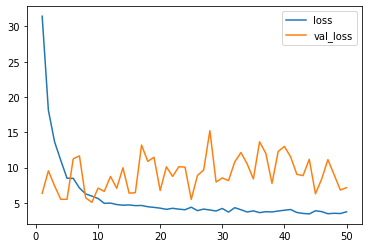

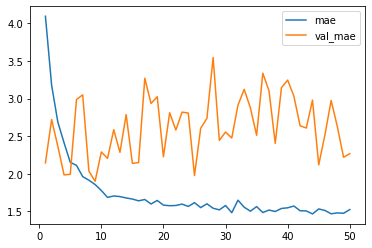

In [176]:
history.history['loss']
history.history['mae']

history.history['val_loss']
history.history['val_mae']

epochs = [i for i in range(1,len(history.history['loss'])+1)]

plt.figure()
plt.plot(epochs,history.history['loss'], label='loss')
plt.plot(epochs,history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs,history.history['mae'], label='mae')
plt.plot(epochs,history.history['val_mae'], label='val_mae')
plt.legend()
plt.show()

In [177]:
# forecast_model.predict([y_val_temp,x_val_temp])
n_preds = 3
yhat = forecast_model.predict([y_val_temp[:n_preds],x_val_temp[:n_preds]])
yhat

1/1 [==============================] - 1s 695ms/step


array([[7.424203 ],
       [7.619315 ],
       [6.7710466]], dtype=float32)

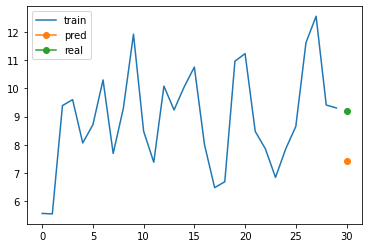

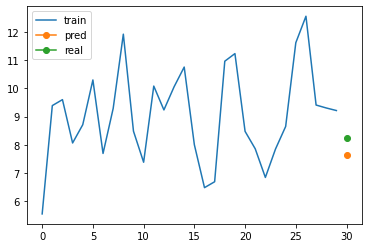

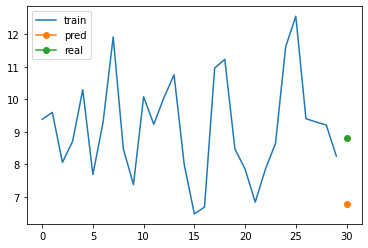

In [178]:

for i in range(n_preds):
    x = np.arange(0,y_val_temp.shape[1]+1)
    plt.figure()
    plt.plot(x[:y_val_temp.shape[1]],y_val_temp[i], label='train')
    plt.plot(x[y_val_temp.shape[1]:],yhat[i], marker='o', label='pred')
    plt.plot(x[y_val_temp.shape[1]:],y_val_target[i], marker='o', label='real')
    plt.legend()